In [1]:
import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [3]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

In [4]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/Single_cell_public_datasets/HumanEndometrium314K/'

OUTPUT_PATH = 'outputs/'


# Load dataset

The example endometrium dataset is from the paper: Marecková, M. et al. An integrated single-cell reference atlas of the human endometrium. Nat Genet 56 (2024). This is a high-resolution single-cell reference atlas combining published and new endometrial single-cell transcriptomics datasets of 63 women with and without endometriosis. The Endometrium dataset contains 313,527 cells, 17736 genes and 36 cell types. The Endometrium dataset can be downloaded through the web portal: https://www.reproductivecellatlas.org/endometrium_reference.html. 

In [5]:
adata = sc.read_h5ad(DATA_PATH + 'endometriumAtlasV2_cells_with_counts.h5ad')


In [6]:
# set batch key

adata.obs['batch'] = adata.obs['sample']

# Preprocess

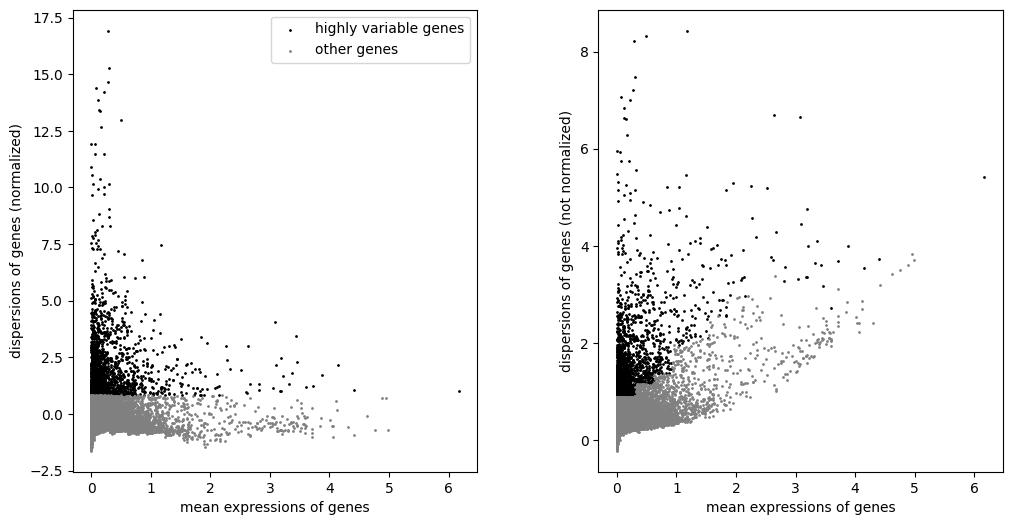

In [7]:
# data is normalized

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)


In [8]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]

# Feature encoder

In [9]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 8], # Encoder dimension in each layer
                   D_decode_list=[8, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000,     # number of epoch
                   lr=1e-3,            # learning rate
                   device=device)


2025-07-21 16:04:29,061 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-07-21 16:04:36,081 - ------------------------> Epoch: 1/2000, Current loss: 199342400.0000
2025-07-21 16:05:00,001 - ------------------------> Epoch: 51/2000, Current loss: 70212496.0000
2025-07-21 16:05:23,938 - ------------------------> Epoch: 101/2000, Current loss: 63010008.0000
2025-07-21 16:05:47,887 - ------------------------> Epoch: 151/2000, Current loss: 59214320.0000
2025-07-21 16:06:11,829 - ------------------------> Epoch: 201/2000, Current loss: 56178776.0000
2025-07-21 16:06:35,779 - ------------------------> Epoch: 251/2000, Current loss: 53896

# Integration - high throughput mode

In [10]:
cd.inte.integration_high_throughput_mode(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            max_epoch=2000,    # number of epoch
                            lr=1e-3,           # learning rate
                            time_increment_diffusion=0.5, # Suggested value==0.5 for high throughput mode.
                            device=device)

2025-07-21 16:20:40,768 - --------> Build diffusion graph for data integration ...
2025-07-21 16:25:13,339 - --------> Diffusion graph is completed.
2025-07-21 16:25:13,340 - --------> Build KNN_adj for loss function ...
2025-07-21 16:25:13,996 - --------> KNN_adj is completed.
2025-07-21 16:25:13,997 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/Pan_proj/sc_integration/integration_DIF.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-07-21 16:25:14,566 - ------------------------> Epoch: 1/2000, Current loss: 67803865088.0000
2025-07-21 16:25:36,359 - ------------------------> Epoch: 51/2000, Current loss: 1351155328.0000
2025-07-21 16:25:58,150 - ------------------------> Epoch: 101/2000, Current loss: 1256

## View integrated embeddings

In [11]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=8)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/diffusion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


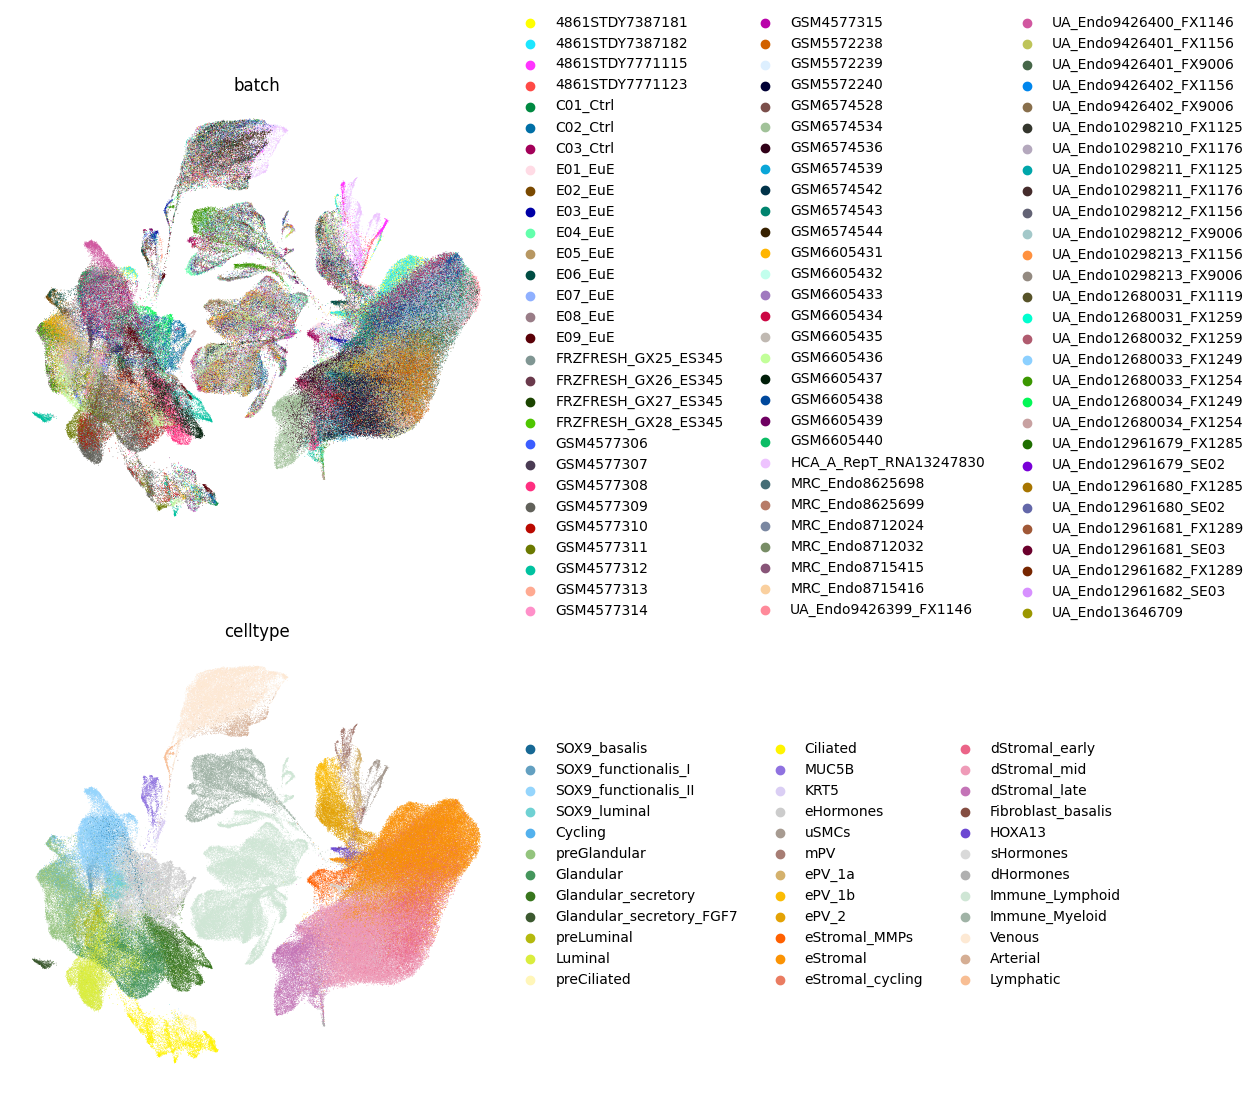

In [12]:
sc.pl.umap(adata, color=['batch', 'celltype'], frameon=False, size=1, ncols=1)

# Save integrated data

In [13]:
# adata.write(OUTPUT_PATH + 'scDiffusion_integration.h5ad')

In [14]:
# adata = ad.read_h5ad(OUTPUT_PATH + 'scDiffusion_integration.h5ad')
